In [1]:
!pip install prophet


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import numpy as np
from prophet import Prophet
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import os

In [18]:

def get_stock_data_by_symbol(symbol:str):
    url = "https://alpha.financeapi.net/symbol/get-chart?period=MAX&symbol="+symbol

    payload={}
    headers = {
    'X-API-KEY': os.getenv('YAHOO_TOKEN')
    }

    response = requests.request("GET", url, headers=headers, data=payload)
    print(response.status_code)
    response_json = response.json()
    if 'attributes' in response_json:
        return pd.DataFrame(response_json['attributes']).T
    else:
        return pd.DataFrame()

In [19]:
df = get_stock_data_by_symbol('GOOG')
df.head()

200


,open,high,low,close,volume,adj
2014-03-31 00:00:00,28.343722,30.240670,27.149255,27.156254,232618227.0,1.0
2014-04-07 00:00:00,27.036258,28.267724,26.325777,26.529272,376222949.0,1.0
2014-04-14 00:00:00,26.911761,27.849235,25.922293,26.804264,361825034.0,1.0
2014-04-21 00:00:00,26.804264,26.860763,25.770292,25.808291,219024613.0,1.0
2014-04-28 00:00:00,25.858290,26.699262,25.139310,26.395775,227032153.0,1.0


<AxesSubplot:>

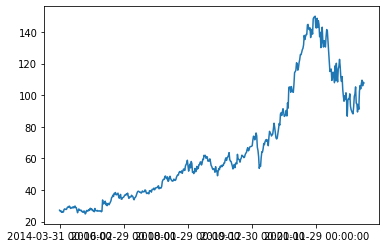

In [20]:
df['close'].plot()

In [21]:
data = df[['close']]
data.head()

,close
2014-03-31 00:00:00,27.156254
2014-04-07 00:00:00,26.529272
2014-04-14 00:00:00,26.804264
2014-04-21 00:00:00,25.808291
2014-04-28 00:00:00,26.395775


In [22]:
data = data.reset_index()
data.head()

,index,close
0,2014-03-31 00:00:00,27.156254
1,2014-04-07 00:00:00,26.529272
2,2014-04-14 00:00:00,26.804264
3,2014-04-21 00:00:00,25.808291
4,2014-04-28 00:00:00,26.395775


In [23]:
data = data.rename(columns={'index': 'ds', 'close': 'y'})

In [24]:
# Import necessary libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

data = data.dropna()

# Split data into train and test datasets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Print number of rows in each dataset
print('Number of rows in train dataset:', len(train_data))
print('Number of rows in test dataset:', len(test_data))

# Rename columns to match Prophet's requirements
#data = data.rename(columns={'Date': 'ds', 'Close': 'y'})

# Create Prophet model
model = Prophet()

# Train model
model.fit(train_data)

# Make predictions on test data
future = model.make_future_dataframe(periods=len(test_data))
predictions = model.predict(future)[-len(test_data):]

# Calculate MAE
mae = mean_absolute_error(test_data['y'], predictions['yhat'])
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data['y'], predictions['yhat']))

# Print evaluation metrics
print('MAE:', mae)
print('RMSE:', rmse)

18:33:25 - cmdstanpy - INFO - Chain [1] start processing


Number of rows in train dataset: 380
Number of rows in test dataset: 95


18:33:26 - cmdstanpy - INFO - Chain [1] done processing


MAE: 19.143253915571155
RMSE: 21.04522053838447


In [25]:
print(predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds        yhat  yhat_lower  yhat_upper
470 2021-10-04  123.662916  118.463010  129.215826
471 2021-10-05  123.794242  118.661955  129.478617
472 2021-10-06  123.930813  118.161236  129.500852
473 2021-10-07  124.072530  118.507505  129.582710
474 2021-10-08  124.219251  118.635003  129.682468


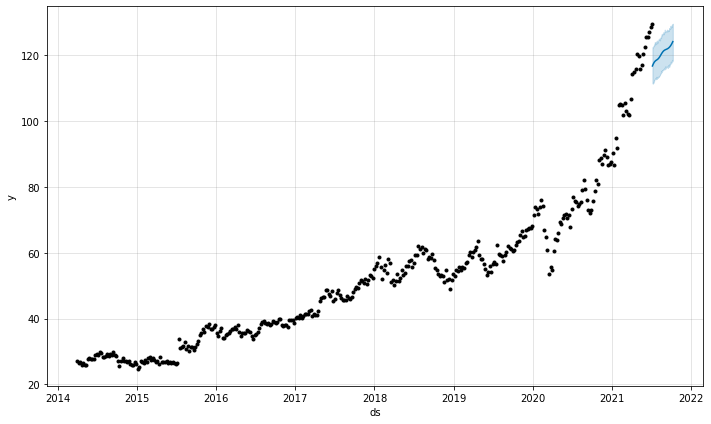

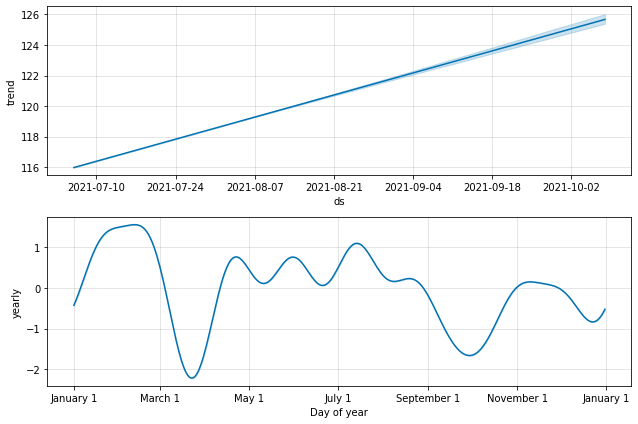

In [26]:
figure1 = model.plot(predictions)
figure2 = model.plot_components(predictions)

In [27]:
import pandas as pd

# create a time range with a frequency of 1 day
time_range = pd.date_range(start='2021-09-01', end='2021-09-30', freq='D')

# create an empty dataframe with the time range as the index
df = pd.DataFrame(index=time_range)
df.index = pd.to_datetime(df.index)
# print the empty dataframe
df.head()

""
2021-09-01
2021-09-02
2021-09-03
2021-09-04
2021-09-05


In [28]:
df_future = predictions
df_future.ds = pd.to_datetime(df_future.ds)
df_future = df_future.set_index('ds')
df_future.tail()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2021-10-04,125.260848,118.463010,129.215826,125.000123,125.581098,-1.597932,-1.597932,-1.597932,-1.597932,-1.597932,-1.597932,0.0,0.0,0.0,123.662916
2021-10-05,125.363965,118.661955,129.478617,125.095913,125.693097,-1.569723,-1.569723,-1.569723,-1.569723,-1.569723,-1.569723,0.0,0.0,0.0,123.794242
2021-10-06,125.467082,118.161236,129.500852,125.192332,125.803911,-1.536269,-1.536269,-1.536269,-1.536269,-1.536269,-1.536269,0.0,0.0,0.0,123.930813
2021-10-07,125.570198,118.507505,129.582710,125.292012,125.912597,-1.497668,-1.497668,-1.497668,-1.497668,-1.497668,-1.497668,0.0,0.0,0.0,124.072530
2021-10-08,125.673315,118.635003,129.682468,125.390960,126.024321,-1.454064,-1.454064,-1.454064,-1.454064,-1.454064,-1.454064,0.0,0.0,0.0,124.219251


In [29]:
df_test = test_data
df_test.ds = pd.to_datetime(df_test.ds)
df_test = df_test.set_index('ds')
df_test.tail()

,y
ds,
2023-04-03,107.43
2023-04-10,109.46
2023-04-17,105.91
2023-04-24,108.22
2023-05-01,107.71


In [30]:
df1 = df_future.join(df_test)

In [31]:
df1.tail()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,
2021-10-04,125.260848,118.463010,129.215826,125.000123,125.581098,-1.597932,-1.597932,-1.597932,-1.597932,-1.597932,-1.597932,0.0,0.0,0.0,123.662916,140.056
2021-10-05,125.363965,118.661955,129.478617,125.095913,125.693097,-1.569723,-1.569723,-1.569723,-1.569723,-1.569723,-1.569723,0.0,0.0,0.0,123.794242,NaN
2021-10-06,125.467082,118.161236,129.500852,125.192332,125.803911,-1.536269,-1.536269,-1.536269,-1.536269,-1.536269,-1.536269,0.0,0.0,0.0,123.930813,NaN
2021-10-07,125.570198,118.507505,129.582710,125.292012,125.912597,-1.497668,-1.497668,-1.497668,-1.497668,-1.497668,-1.497668,0.0,0.0,0.0,124.072530,NaN
2021-10-08,125.673315,118.635003,129.682468,125.390960,126.024321,-1.454064,-1.454064,-1.454064,-1.454064,-1.454064,-1.454064,0.0,0.0,0.0,124.219251,NaN


200
200
200
200
200
200
200
200
200
200
200


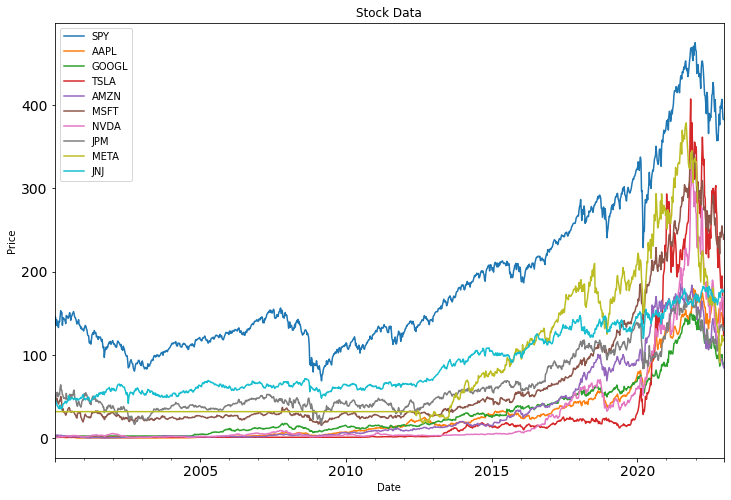

In [32]:
"""Fill missing values"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def fill_missing_values(df_data):
    return df_data.ffill().bfill()


def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df_final = pd.DataFrame(index=dates)
    if "SPY" not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, "SPY")

    for symbol in symbols:
        # file_path = symbol_to_path(symbol)
        df_temp = get_stock_data_by_symbol(symbol)
        if not df_temp.empty:
            df_temp = df_temp[['close']]
            df_temp.index = pd.to_datetime(df_temp.index)
            df_temp = df_temp.rename(columns={"close": symbol})
            df_final = df_final.join(df_temp)
            if symbol == "SPY":  # drop dates SPY did not trade
                df_final = df_final.dropna(subset=["SPY"])

    return df_final


def plot_data(df_data):
    """Plot stock data with appropriate axis labels."""
    fig, ax = plt.subplots(figsize=(12, 8))
    df_data.plot(ax=ax, title="Stock Data", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()


def test_run():
    """Function called by Test Run."""
    # Read data
    symbol_list = ["AAPL", "GOOGL", "TSLA", "AMZN", "FB", "MSFT", "NVDA", "JPM", "META", "JNJ"]  # list of symbols
    start_date = "2000-01-01"
    end_date = "2022-12-31"
    dates = pd.date_range(start_date, end_date)  # date range as index
    df_data = get_data(symbol_list, dates)  # get data for each symbol

    # Fill missing values
    df_data = fill_missing_values(df_data)

    # Plot
    plot_data(df_data)


if __name__ == "__main__":
    test_run()


In [33]:
def get_data_for_training(symbol, start_date, end_date):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df_final = pd.DataFrame(index=pd.date_range(start_date, end_date))
   #  file_path = symbol_to_path(symbol)
    df_temp = get_stock_data_by_symbol(symbol)
    if df_temp.empty:
        raise 'Symbol invalid or with empty stock data!'
    df_temp = df_temp[['close']]
    df_temp.index = pd.to_datetime(df_temp.index)
    df_final = df_final.join(df_temp)
    df_final = df_final.ffill().bfill()
    return df_final

In [51]:
start_date = "2000-01-01"
end_date = "2021-12-31"
df_train = get_data_for_training("META",start_date,end_date)
start_date = "2000-01-01"
end_date = "2022-12-31"
df_test = get_data_for_training("META",start_date,end_date)

200
200


In [54]:
df_train = df_train[['close']]
df_train = df_train.reset_index()
df_train = df_train.rename(columns={'index': 'ds', 'close': 'y'})
df_train.tail()

KeyError: "None of [Index(['close'], dtype='object')] are in the [columns]"

18:36:55 - cmdstanpy - INFO - Chain [1] start processing
18:36:57 - cmdstanpy - INFO - Chain [1] done processing


MAE: 14.679313183196646
RMSE: 38.310287526708166


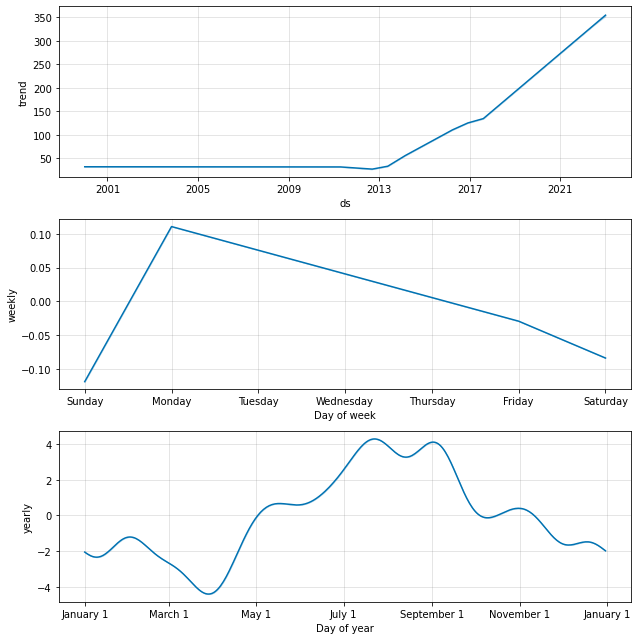

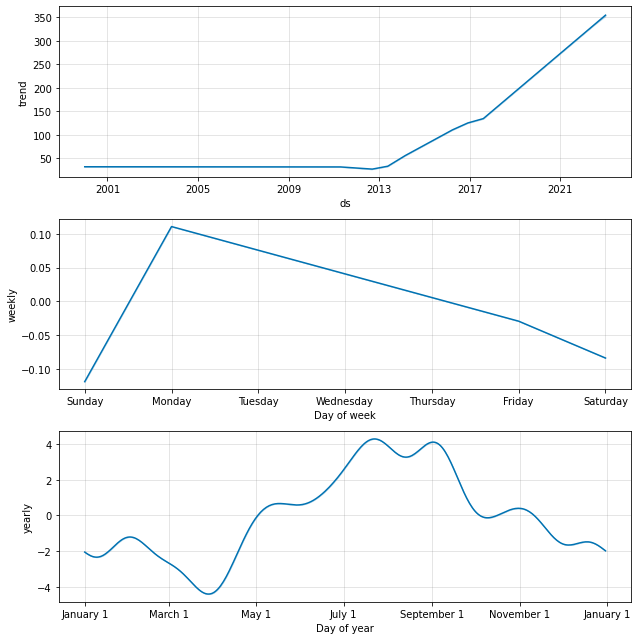

In [55]:
# Import necessary libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

# Create Prophet model
model = Prophet()

# Train model
model.fit(df_train)

# Make predictions on test data
future = model.make_future_dataframe(periods=365, freq='D')
predictions = model.predict(future)

# Calculate MAE
mae = mean_absolute_error(df_test['close'], predictions['yhat'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df_test['close'], predictions['yhat']))

#Print evaluation metrics
print('MAE:', mae)
print('RMSE:', rmse)


model.plot_components(predictions)

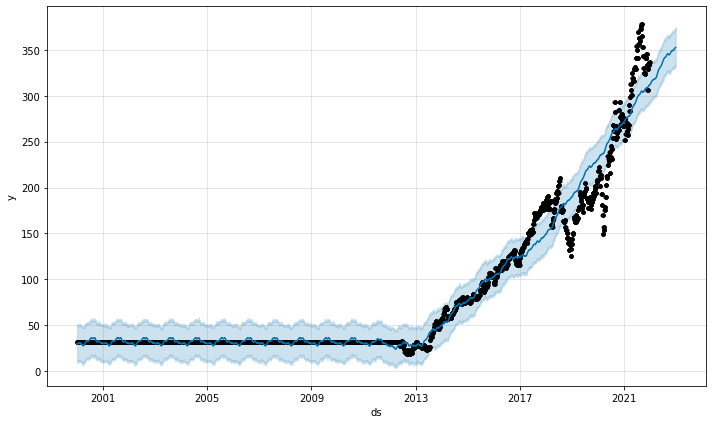

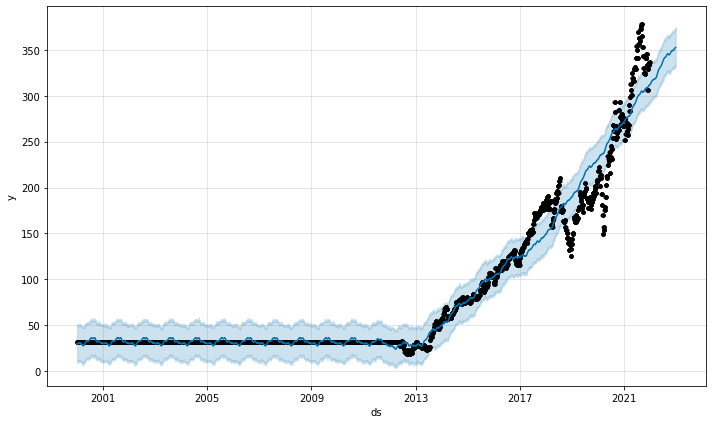

In [56]:
model.plot(predictions)

<AxesSubplot:>

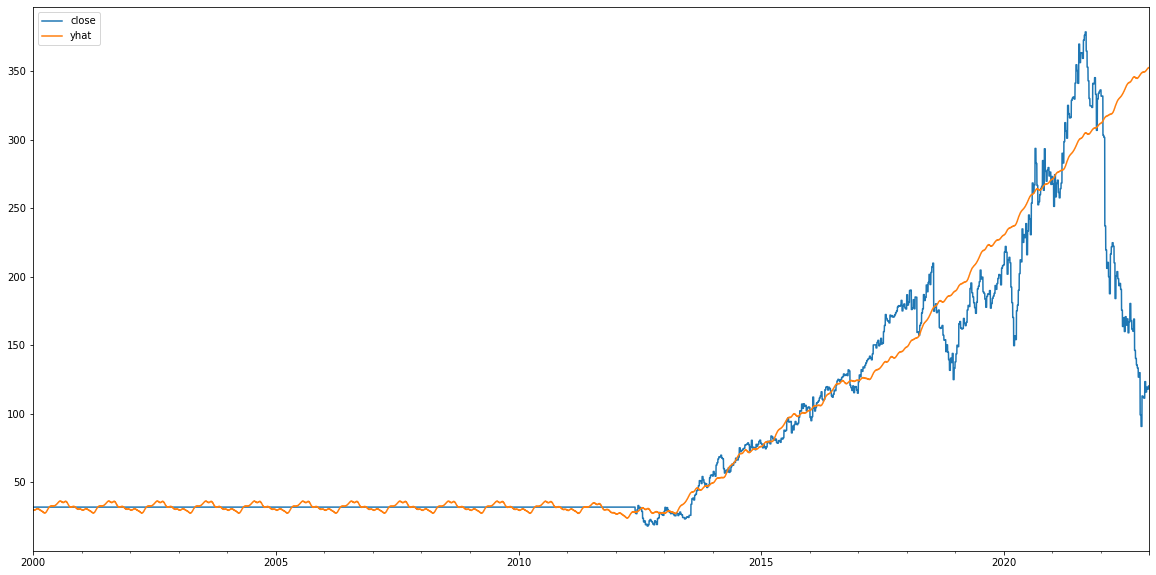

In [57]:

predictions = predictions[['ds','yhat']]
predictions = predictions.set_index('ds')
df_of = df_test.join(predictions)
df_of.plot(figsize=(20,10))

In [58]:
df_test.shape

(8401, 1)

In [40]:
df_of = df_test.join(predictions)

<AxesSubplot:>

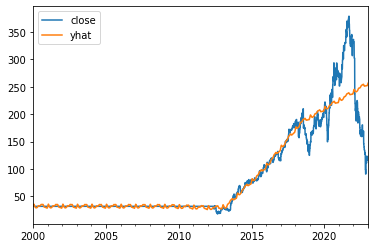

In [41]:
df_of.plot()

In [42]:
# IBM GE AAPL   / TSLA META 

In [43]:
def plot_data(df, title="Stock prices"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()


def get_rolling_mean(values, window):
    """Return rolling mean of given values, using specified window size."""
    return values.rolling(window=window, center=False).mean()

def get_rolling_std(values, window):
    """Return rolling standard deviation of given values, using specified window size."""
    # TODO: Compute and return rolling standard deviation
    return values.rolling(window=window, center=False).std()

def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    # TODO: Compute upper_band and lower_band
    
    upper_band = rm + rstd * 2 # Calculate top band
    lower_band = rm - rstd * 2 # Calculate bottom band
    return upper_band, lower_band


200


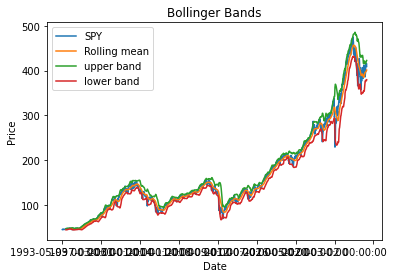

In [44]:
# Compute Bollinger Bands
# 1. Compute rolling mean
df = get_stock_data_by_symbol('SPY')
rm_SPY = get_rolling_mean(df['close'], window=20)

# 2. Compute rolling standard deviation
rstd_SPY = get_rolling_std(df['close'], window=20)

# 3. Compute upper and lower bands
upper_band, lower_band = get_bollinger_bands(rm_SPY, rstd_SPY)

# Plot raw SPY values, rolling mean and Bollinger Bands
ax = df['close'].plot(title="Bollinger Bands", label='SPY')
rm_SPY.plot(label='Rolling mean', ax=ax)
upper_band.plot(label='upper band', ax=ax)
lower_band.plot(label='lower band', ax=ax)

# Add axis labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc='upper left')
plt.show()

In [45]:
def plot_data(df, title="Stock prices", xlabel="Date", ylabel="Price"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()


def compute_daily_returns(df):
    """Compute and return the daily return values."""
    # TODO: Your code here
    # Note: Returned DataFrame must have the same number of rows
    return df[:-1] / df[1:].values - 1


def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df_final = pd.DataFrame(index=dates)
    if "SPY" not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, "SPY")

    for symbol in symbols:
        # file_path = symbol_to_path(symbol)
        df_temp = get_stock_data_by_symbol(symbol)
        if not df_temp.empty:
            df_temp = df_temp[['close']]
            df_temp.index = pd.to_datetime(df_temp.index)
            df_temp = df_temp.rename(columns={"close": symbol})
            df_final = df_final.join(df_temp)
            if symbol == "SPY":  # drop dates SPY did not trade
                df_final = df_final.dropna(subset=["SPY"])

    return df_final

200
200


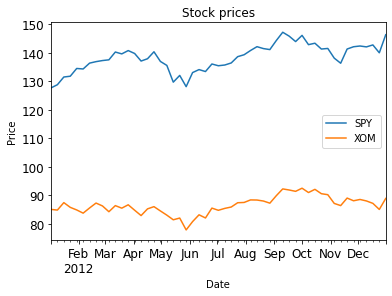

                 SPY    XOM
2012-01-02  127.7100  85.12
2012-01-09  128.8400  84.88
2012-01-16  131.5400  87.49
2012-01-23  131.8200  85.83
2012-01-30  134.5400  84.92
2012-02-06  134.3610  83.80
2012-02-13  136.4100  85.62
2012-02-20  136.9300  87.34
2012-02-27  137.3120  86.33
2012-03-05  137.5700  84.30
2012-03-12  140.3000  86.44
2012-03-19  139.6500  85.55
2012-03-26  140.8100  86.73
2012-04-02  139.7900  84.82
2012-04-09  137.1400  82.95
2012-04-16  137.9500  85.30
2012-04-23  140.3900  86.08
2012-04-30  137.0000  84.57
2012-05-07  135.6100  83.10
2012-05-14  129.7400  81.47
2012-05-21  132.1000  82.08
2012-05-28  128.1600  77.92
2012-06-04  133.1000  80.84
2012-06-11  134.1400  83.22
2012-06-18  133.4600  82.11
2012-06-25  136.1050  85.57
2012-07-02  135.4900  84.80
2012-07-09  135.7500  85.47
2012-07-16  136.4700  85.95
2012-07-23  138.6750  87.45
2012-07-30  139.3490  87.55
2012-08-06  140.8400  88.44
2012-08-13  142.1800  88.40
2012-08-20  141.5100  88.05
2012-08-27  141.1600

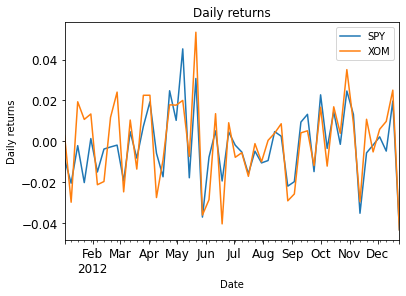

In [46]:
# Read data
dates = pd.date_range('2012-01-01', '2012-12-31')  # one month only
symbols = ['SPY','XOM']
df = get_data(symbols, dates)
plot_data(df)
print(df)
# Compute dprint(df)aily returns
daily_returns = compute_daily_returns(df)
plot_data(daily_returns, title="Daily returns", ylabel="Daily returns")